# More COBRA models

Now that we have the basics down, let's try some other analysis

## Flux Variability Analysis.

Recall that FVA holds an objective function constant, and then optimizes for the minimum and maximum value of each flux that can maintain that maximum. Think of this as exploring the flat edges of a high-dimensional polygon.

In [1]:
from cobra.io import read_sbml_model

In [2]:
model = read_sbml_model('data/iJO1366.xml.gz')

In [4]:
from cobra.flux_analysis import flux_variability_analysis

In [5]:
fvaresults = flux_variability_analysis(model)
fvaresults
subset = fvaresults.sort_values(by='maximum').head(15) # This will just take the first 15 entries, sorted by maximum

In [6]:
fvaresults

,minimum,maximum
DM_4crsol_c,0.000219,2.190689e-04
DM_5drib_c,0.000221,2.210337e-04
DM_aacald_c,0.000000,0.000000e+00
DM_amob_c,0.000002,1.964744e-06
DM_mththf_c,0.000440,4.401026e-04
...,...,...
ZN2abcpp,0.000000,1.092904e-12
ZN2t3pp,0.000000,4.371614e-12
ZN2tpp,0.000335,3.349888e-04
ZNabcpp,0.000000,1.412211e-12


<BarContainer object of 15 artists>

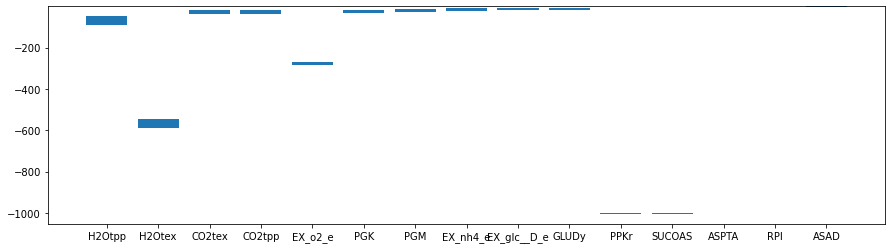

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"]=15,4
plt.bar(x=subset.index, height=subset.maximum, bottom = subset.minimum) 
   
    # check out https://matplotlib.org/3.2.1/api/_as_gen/matplotlib.pyplot.bar.html

In [ ]:
model.optimize()
model.summary(fva=0.95)

## Simulating gene deletions

We can take advantage of the gene to reaction linkage to simulate the effect of gene deletions. This is going to be similar to manually setting reaction fluxes to 0, but accounts for more realistic situations:

1. When a gene catalyzes more than one reaction
2. When more than one gene product can catalyze the same reaction

Let's try deleting phosphofructokinase!

First, let's find the associated genes.

In [9]:
model.reactions.query("PFK")

[<Reaction PFK at 0x7ff739294cd0>,
 <Reaction PFK_2 at 0x7ff7392e5f40>,
 <Reaction PFK_3 at 0x7ff739294f70>]

In [10]:
[print(reaction.name, reaction) for reaction in model.reactions.query("PFK")]

Phosphofructokinase PFK: atp_c + f6p_c --> adp_c + fdp_c + h_c
Phosphofructokinase PFK_2: atp_c + tag6p__D_c --> adp_c + h_c + tagdp__D_c
Phosphofructokinase (s7p) PFK_3: atp_c + s7p_c --> adp_c + h_c + s17bp_c


[None, None, None]

In [11]:
model.reactions.PFK.genes

frozenset({<Gene b1723 at 0x7ff73a1c2d90>, <Gene b3916 at 0x7ff73a1c2dc0>})

We see that two genes, b1723 and b3916, encode phosphofructokinase. Let's try single mutants as well as double mutants.

In [12]:
print('complete model: ', model.optimize())
with model: # This format prevents overwriting the original model
    model.genes.b1723.knock_out() # knock_out
    print('pfkA knocked out: ', model.optimize()) 
with model:
    model.genes.b3916.knock_out()
    print('pfkB knocked out: ', model.optimize()) 
with model:
    model.genes.b1723.knock_out()
    model.genes.b3916.knock_out()
    print('pfkB and pfkB knocked out: ', model.optimize()) 

complete model:  <Solution 0.982 at 0x7ff730390280>
pfkA knocked out:  <Solution 0.982 at 0x7ff73039dc10>
pfkB knocked out:  <Solution 0.982 at 0x7ff73039dc70>
pfkB and pfkB knocked out:  <Solution 0.975 at 0x7ff73039dc40>


Unsurprisingly, single deletions don't slow cell growth, because another isoform can (in theory) pick up the slack. But a double deletion isn't so bad in these conditions, either! How could this be the case?

In [13]:
newmodel = model.copy()
newmodel.genes.b1723.knock_out()
newmodel.genes.b3916.knock_out()
nopfk = newmodel.optimize()

In [14]:
import escher
escher.Builder(map_name='iJO1366.Central metabolism',
                   model = newmodel,
                   reaction_data=dict(nopfk.fluxes))

Builder(reaction_data={'DM_4crsol_c': 0.00021748066474178027, 'DM_5drib_c': 0.0002194311639770834, 'DM_aacald_…

Hmm, it seems that F6PA is picking up the slack from the loss of PFK. We can predict that deleting the genes involved in this reaction would be fatal. Let's test.

First, can we check for differences programatically?

In [15]:
diff = newmodel.optimize().fluxes - model.optimize().fluxes

In [16]:
diff.sort_values()

PFK        -6.918811
FBA        -6.918811
GLCptspp   -6.868649
PGI        -5.918065
ADK1       -3.928345
              ...   
XYLI2       6.034659
HEX7        6.034659
GLCt2pp     6.868649
DHAPT       6.963875
F6PA        6.963875
Name: fluxes, Length: 2583, dtype: float64

Yes, F6PA and DHAPT seem to increase in flux just as much as PFK and FBA drop.

In [17]:
newmodel.reactions.F6PA.genes

frozenset({<Gene b0825 at 0x7ff730281340>, <Gene b3946 at 0x7ff730281370>})

There are two genes involved with F6PA, let's delete both of them and see if our quadruple mutant survives.

In [18]:
with newmodel:
    newmodel.genes.b0825.knock_out()
    print('F6PA_1 knocked out: ', newmodel.optimize()) 
with newmodel:
    newmodel.genes.b0825.knock_out()
    newmodel.genes.b3946.knock_out()
    print('F6PA_1 and F6PA_2 knocked out: ', newmodel.optimize()) 

F6PA_1 knocked out:  <Solution 0.975 at 0x7ff73034ffa0>
F6PA_1 and F6PA_2 knocked out:  <Solution 0.946 at 0x7ff72acd14f0>


What have we learned from this? We've demonstrated that central metabolism in E. coli can be very robust to gene deletions! And by using mass balance, we can see that textbook components of glycolysis can be removed with very little change in growth rate. With some loops, you could fairly easily write a script to test the effect of every pairwise, triple or quadruple mutant!

## Finding all essential genes

We've seen how we could go through cycles of hypothesis generation and prediction, and we can foresee how a brute force approach could work. Let's take a brute force approach to identify all essential genes.

Fortunately, cobrapy has a function to do this for us.

In [19]:
from cobra.flux_analysis import find_essential_genes
essential = find_essential_genes(model)
[print(gene.name) for gene in essential];

ribF
lpxK
moaD
waaA
luxS
dapD
kdsB
glmU
panB
mog
cysI
cysJ
purH
thiI
murJ
hemL
moaE
thiS
moeB
thiF
thiH
metF
cysD
gpsA
thyA
cysN
ispB
hemH
thiL
serC
thiE
pyrF
dapE
ubiX
ubiD
cysE
pyrE
trpA
trpB
nadK
nadE
proC
thiG
lpxD
murE
cysG
panC
lpxA
murA
mraY
cysH
murG
metB
murD
murC
murB
pdxJ
aldA
pdxA
ispU
nadD
pdxB
nadC
glmS
hemE
lpxC
glmM
murF
hemD
ribB
lptG
aroC
fabI
argG
nadA
bioD
cdsA
lptB
lptC
ubiC
fabH
lpxH
asd
argE
pheA
tyrA
lptA
dapF
lptF
gmk
hisD
hisB
argD
ilvD
fabZ
panD
bioH
coaA
fabG
pyrB
fabB
thiD
hemC
dapB
pabC
nadB
dapA
murI
purF
folK
aspC
pabA
pabB
lpxB
purA
thrB
folC
hemB
msbA
gltX
hemA
hisC
thrC
dfp
metA
folB
moaA
moaC
pyrC
folP
mtn
hemG
bioC
aroB
acpP
aroD
ispA
purD
hisG
iscS
purM
ispH
hisI
bioA
cyaY
purC
gltA
purL
thiC
hisA
icd
pyrG
aroA
fabD
cysC
psd
purB
moeA
hisH
pssA
hisF
guaA
trpD
mobA
trpE
trpC
ilvE
coaD
bioF
coaE

cysQ
bioB
ilvC
accB
ribD
plsC
argC
accA
leuB
accD
leuC
leuD
ispG
leuA
ispF
yrbG
tmk
accC
ispD
kdsC
purK
purE
metK
kdsA
argB
argA
folE
lysA
ubiA
ribE
argH
dx

# Pathway engineering

By now I hope I've demonstrated how we can use genome-scale metabolic models to predict phenotypes. 
Can we now use this approach to tie new pathways into a cell, and estimate whether if we can produce reasonable yields? Can we predict changes in growth rate?

We'll create some reactions and metabolites first, and then place them into the model. We'll need to import some functions from cobra to do this.

In [20]:
from cobra import Reaction, Metabolite
model = read_sbml_model('data/iJO1366.xml.gz')

We'll create a reaction called alchemy

In [21]:
new_reaction = Reaction('alchemy')

It will turn phosphate into gold, so we'll need to define gold as a metabolite.

In [22]:
gold = Metabolite(id='gold_c', compartment='c', name='GOLD')

Now that we have a metabolite, we can construct a reaction around it. We'll add metabolites to the reaction object. We'll have an ATP consumed, generating gold and an ATP. This will permantly remove a phosphate from the system, but return ADP as a metabolite.

In [23]:
new_reaction.add_metabolites({model.metabolites.atp_c: -1, gold: 1, model.metabolites.adp_c: 1})

We'll add the new reaction to the model. Note that the add_reactions method requires a list input, even if it is just one item.

In [24]:
model.add_reactions([new_reaction])

If we were to run the simulation now, it would fail to produce gold, because there is no demand being placed upon it. Rather than an export reaction, we'll say that gold is leaving the system. We can define a new boundary condition as follows.

In [25]:
model.add_boundary(model.metabolites.gold_c, type='demand')

Reaction identifier,DM_gold_c
Name,GOLD demand
Memory address,0x07ff72ab47f70
Stoichiometry,gold_c --> GOLD -->
GPR,
Lower bound,0
Upper bound,1000.0


We're still going to use the biomass objective function, so there will be no "incentive" to produce gold. We'll force the system by introducing a positive, lower boundary.

In [26]:
model.reactions.alchemy.bounds = (200, 1000)

In [27]:
model.reactions.alchemy

Reaction identifier,alchemy
Name,
Memory address,0x07ff7280add90
Stoichiometry,atp_c --> adp_c + gold_c ATP --> ADP + GOLD
GPR,
Lower bound,200
Upper bound,1000


In [28]:
model.objective.expression

1.0*BIOMASS_Ec_iJO1366_core_53p95M - 1.0*BIOMASS_Ec_iJO1366_core_53p95M_reverse_5c8b1

In [29]:
opt = model.optimize()

In [30]:
print("Biomass flux:", opt.fluxes.BIOMASS_Ec_iJO1366_core_53p95M)
print("Gold flux:", opt.fluxes.alchemy)

Biomass flux: 0.13594895431633267
Gold flux: 200.0


We can see that this puts a heavy burden on cell growth rates. We can predict that the cell would be starved of phosphate, and by using some of the analytical tools described so far (reduced costs, shadow price, FVA), you could imagine how we could go about determining bottlenecks.

We could also do a deletion series and see if there are any E. coli proteins that are now detrimental for growth under these conditions. Maybe their deletion would have slowed growth in non-productive cells, but now perhaps there pathways that act as a drain on the system.

This wraps up the basics, but going forward, there are lots of approaches to formalize strain engineering by considering growth rates!